# Trees

## Credit Risk Scoring Task

- We has financial organization want based on information about client make a decision to provide Loan
    - We want to make a model to make such decisions (Scoring Model)
    - What is the Risk of Default for the client
    

The way we can do this:
- we can analyze historical data (info about clients and their statuses default or not)

We need a model which for every client give us a probability of default

### Data  
In this project, we will use Credit Scoring dataset: [credit_scoring_dataset](https://github.com/gastonstat/CreditScoring/blob/master/CreditScoring.csv)

In [1]:
# imports
from IPython.display import display

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
import graphviz
from sklearn.feature_extraction import DictVectorizer

# random forest:
from sklearn.ensemble import RandomForestClassifier

#xgboost:
import xgboost as xgb

from sklearn.metrics import roc_auc_score

### Data Cleaning

In [2]:
df = pd.read_csv('./data/CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


1. Status - credit status (target variable)
2. Seniority - job seniority (years)
3. Home - type of home ownership
4. Time - time of requested loan
5. Age - client's age
6. Marital - marital status
7. Records - existance of records
8. Job - type of job
9. Expenses - amount of expenses
10. Income - amount of income
11. Assets - amount of assets
12. Debt - amount of debt
13. Amount - amount requested of loan
14. Price - price of good

In [3]:
# format column names:
df.columns = df.columns.str.lower()

In [4]:
# let's take a look at the target variable:
df['status'].unique()

array([1, 2, 0], dtype=int64)

we can see that the field is not binary and consists of 3 different values:
- 1 - Client is not in Default
- 2 - Client in Default
- 0 - No information

In [5]:
# map target variable:
df['status'] = df['status'].map({
    1: 'ok',
    2: 'default',
    0: 'unk'
})

In [6]:
df.head(3)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985


In [7]:
# map other features:

#home:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df['home'] = df['home'].map(home_values)
# matrital:
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df['marital'] = df['marital'].map(marital_values)
# records:
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df['records'] = df['records'].map(records_values)
#jobs:
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df['job'] = df['job'].map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [9]:
# deal with missing values:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


we can see that: income, assets, and debt columns have high values consisting of 9 digits, which are actually missing values, therefore we can replace such values with NA:

In [10]:
# max value in columns: 99999999
for column in ['income', 'assets', 'debt']:
    df[column] = df[column].replace(to_replace=99999999, value=np.nan)


In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [12]:
# fill missing values with 0:
df = df.fillna(0)

now we do not see such high values in any column

we also have missing values in target variable, which is useless for our purpose of model creation

In [13]:
# filter rows with missing target variable:
df = df[df['status'] != 'unk'].reset_index(drop=True)

## Train test split:

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)
#reset_indexes:
df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

n = len(df)
n_full_train = len(df_full_train)
n_train = len(df_train)
n_val  = len(df_val)
n_test = len(df_test)
print(f'total number of records: {n}')
print(f'n_train: {n_train}')
print(f'n_val: {n_val}')
print(f'n_test: {n_test}')
print(f'check sum: {n_train + n_val + n_test}')

total number of records: 4454
n_train: 2672
n_val: 891
n_test: 891
check sum: 4454


In [15]:
# target variable:
df_train['status'].head(3)

0    default
1    default
2         ok
Name: status, dtype: object

since we decoded values, now we have text value, but for model training we need encode values again, but in the other manner than it was:

In [16]:
# convert into binary format:
df_full_train['status'] = (df_full_train['status'] == 'default').astype(int)
df_train['status'] = (df_train['status'] == 'default').astype(int)
df_val['status'] = (df_val['status'] == 'default').astype(int)
df_test['status'] = (df_test['status'] == 'default').astype(int)

#assign target variables separately:
y_full_train = df_full_train['status'].values
y_train = df_train['status'].values
y_val = df_val['status'].values
y_test = df_test['status'].values

# remove target from dataset:
del df_full_train['status']
del df_train['status']
del df_val['status']
del df_test['status']

# Decision Trees  

![](./pic/1.png)

decision tree can be simply coded as a function (rules):

In [17]:
# function similar to decision tree:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [18]:
xi = df_train.iloc[0].to_dict()

In [19]:
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [20]:
assess_risk(xi)

'ok'

that is example how Decision Tree can make predictions

Such rules can be learned from the data by Model

For now we will select all features for the model

In [21]:
# turn data into Dictionaries to use One-hot encoding later
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

# train DictVectorizer:
dv = DictVectorizer(sparse=False)
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
# test performance:
y_pred = dt.predict_proba(X_val)[:, 1] # we take 2nd column - probability that customer going to Default
y_pred[:10]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

We can see that in the result we have 1 and 0:
- 1 customer is going to default
- 2 customer is going to be Ok

In [24]:
# compute roc auc score: (on validation set)
roc_auc_score(y_val, y_pred)

0.6429457993267297

The ROC AUC score on validation data is not really impressive

In [25]:
# compute roc_auc_score on validation set:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

And on Train data we see that the ROC AUC score = 1!  
- this is one of the signs of Overfitting

# Overfitting

- Model memorizes the data
- Then we model sees new example - it fails in its prediction
- Fail to Generalize

the reason why it happens to decision tree = is due to dree may memorize very specific (for example for even 1 sample)

![](./pic/2.png)

the reason for that is due to our dree is very deep (it can create very specific conditions)

- one possible solution - limit depth of tree:
    - for example max_depth = 3:

In [26]:
dt = DecisionTreeClassifier(max_depth=3) # limit max_depth
dt.fit(X_train, y_train)
y_pred_train = dt.predict_proba(X_train)[:, 1]
y_pred_val = dt.predict_proba(X_val)[:, 1]
auc_score_train = roc_auc_score(y_train, y_pred_train)
auc_score_val = roc_auc_score(y_val, y_pred_val)
print(f'roc auc score on Train data = {auc_score_train}')
print(f'roc_auc_score on Validation data = {auc_score_val}')

roc auc score on Train data = 0.7761016984958594
roc_auc_score on Validation data = 0.7389079944782155


Now we can see that the difference between model performance on train and validation datasets is not that high

If we set Max_Depth to 1:

In [27]:
dt = DecisionTreeClassifier(max_depth=1) # limit max_depth
dt.fit(X_train, y_train)
y_pred_train = dt.predict_proba(X_train)[:, 1]
y_pred_val = dt.predict_proba(X_val)[:, 1]
auc_score_train = roc_auc_score(y_train, y_pred_train)
auc_score_val = roc_auc_score(y_val, y_pred_val)
print(f'roc auc score on Train data = {auc_score_train}')
print(f'roc_auc_score on Validation data = {auc_score_val}')

roc auc score on Train data = 0.6282660131823559
roc_auc_score on Validation data = 0.6058644740984719


- we even in that case have not bad performance
- such trees are called **Stamp**:  
![](./pic/3.png)

Even such Stamp is a little worse than Overfitted Model

In [28]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- class: 0
|--- records=yes >  0.50
|   |--- class: 1



C:\Users\dein5\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


we can see here that Decision Stamp has the following rules:
- if there Are records, then Default
- if there are no records then Ok

Now we can try 3 levels:

In [29]:
dt = DecisionTreeClassifier(max_depth=2) # limit max_depth
dt.fit(X_train, y_train)
y_pred_train = dt.predict_proba(X_train)[:, 1]
y_pred_val = dt.predict_proba(X_val)[:, 1]
auc_score_train = roc_auc_score(y_train, y_pred_train)
auc_score_val = roc_auc_score(y_val, y_pred_val)
print(f'roc auc score on Train data = {auc_score_train}')
print(f'roc_auc_score on Validation data = {auc_score_val}')

roc auc score on Train data = 0.7054989859726213
roc_auc_score on Validation data = 0.6685264343319367


we can see that even small tree with only 2 levels is better than overfitted model

In [30]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



C:\Users\dein5\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


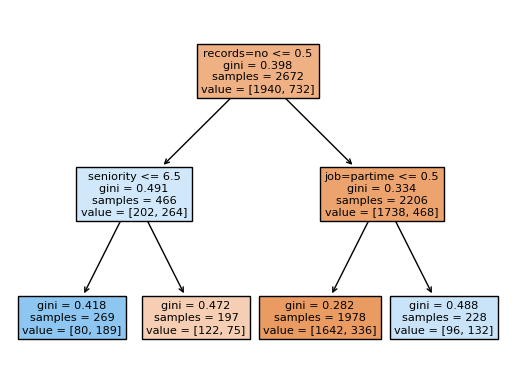

In [31]:
tree_plot = tree.plot_tree(dt, feature_names=dv.get_feature_names(),filled=True)
plt.show()

# Decision Tree Learning Algorithm

- condition node - binary condition (feature < some value) "Leaf" - where we do not go further (deeper)
- Leaf node - where we make a decision
![](./pic/4.png)

to illustrate how algorithm works let's use simple dataset:
- assets
- status

In [32]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default']
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


Now we will train Decision Tree classifier on this data
- question is what is the best Value of Assets which would best divide data on Default and Ok statuses

![](./pic/5.png)

totally we can try only several options here:
- 2000
- 3000
- 4000
- 5000
- 8000  

0 and 9000 does not make sense since such Thresholds would take all data


In [33]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

now we can simply use each Threshold and evaluate which one is the best

In [34]:
for T in Ts:
    print(f'T = {T}')
    df_left = df_example[df_example['assets'] <= T]
    df_right = df_example[df_example['assets'] > T]

    display(df_left)
    display(df_right)

T = 0


,assets,status
2,0,default


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


T = 2000


,assets,status
1,2000,default
2,0,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


T = 3000


,assets,status
1,2000,default
2,0,default
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


T = 4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


T = 5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
0,8000,default
6,9000,ok


T = 8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
6,9000,ok


now we need to evaluate each split:
- assets > T

In [35]:
# for example T = 4000:
T = 4000
df_left = df_example[df_example['assets'] <= T]
df_right = df_example[df_example['assets'] > T]

display(df_left)
display(df_right)

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


what we can do is take a look at the statuses in each split and make a prediction based on the Majority of statuses in the split:
- 3 out of 4 are *ok* in Right part, therefore we can predict Ok for right (T > 4000)
- 3 out of 4 are *default* in Left part, therefore we can predict Default (T <= 4000)

to evaluate out prediction, we can use Misclassification rate 
- Misclassification rate - what is the fraction of error
$$ MisclassificationRate = \frac{Errors}{TotalSizeGroup} $$

In [36]:
display(df_left)
n_errors = len(df_left[df_left['status'] != 'default']) # number of error
n = len(df_left)
misclassification_rate = n_errors / n * 100
print(f'misclassification_rate = {misclassification_rate} %')

print()

display(df_right)
n_errors = len(df_right[df_right['status'] != 'ok']) # number of error
n = len(df_right)
misclassification_rate = n_errors / n * 100
print(f'misclassification_rate = {misclassification_rate} %')

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


misclassification_rate = 25.0 %



,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


misclassification_rate = 25.0 %


we can also take an average to calculate only 1 metric after evaluation of split = (25+25)/2 = 25%  
but we of course better use weighted average, since it one part there could be 1 example and 8 on the right, but here we use average, but real algorithm uses weighted average

obviously, we want to minimize misclassification rate

In [37]:
print('left part:')
print(df_left['status'].value_counts(normalize=True))
print('right part:')
print(df_right['status'].value_counts(normalize=True))


left part:
default    0.75
ok         0.25
Name: status, dtype: float64
right part:
ok         0.75
default    0.25
Name: status, dtype: float64


In [38]:
left_misclassification = df_left['status'].value_counts(normalize=True).min()
if left_misclassification == 1:
    left_misclassification = 0 # case of pure class
right_misclassification = df_right['status'].value_counts(normalize=True).min()
if right_misclassification == 1:
    right_misclassification = 0
average_misclassification = np.mean([left_misclassification, right_misclassification])
print(f'average misclassification = {average_misclassification}')

average misclassification = 0.25


we can simply look at the relation and always pick the smallest value as misclassification rate, since all others would be classified correctly

In [39]:
# check what split is the best:
mis_rates = []
for T in Ts: # theshholds
    print(f'T = {T}')
    df_left = df_example[df_example['assets'] <= T]
    df_right = df_example[df_example['assets'] > T]
    left_misclassification = df_left['status'].value_counts(normalize=True).min()
    if left_misclassification == 1:
        left_misclassification = 0 # case of pure class
    right_misclassification = df_right['status'].value_counts(normalize=True).min()
    if right_misclassification == 1:
        right_misclassification = 0
    average_misclassification = np.mean([left_misclassification, right_misclassification])
    print(f'average misclassification = {average_misclassification}')  
    print(f'left_misclassification = {left_misclassification}')
    print(f'right_misclassification = {right_misclassification}')
    mis_rates.append(average_misclassification)
    print()

T = 0
average misclassification = 0.21428571428571427
left_misclassification = 0
right_misclassification = 0.42857142857142855

T = 2000
average misclassification = 0.16666666666666666
left_misclassification = 0
right_misclassification = 0.3333333333333333

T = 3000
average misclassification = 0.1
left_misclassification = 0
right_misclassification = 0.2

T = 4000
average misclassification = 0.25
left_misclassification = 0.25
right_misclassification = 0.25

T = 5000
average misclassification = 0.5
left_misclassification = 0.5
right_misclassification = 0.5

T = 8000
average misclassification = 0.21428571428571427
left_misclassification = 0.42857142857142855
right_misclassification = 0



**Misclassification rate** is only one way of measuring **impurity**
- impurity - we want our leafs to be as pure as possible

We can see that the best Threshold is 3000, since it has the lowest average Misclassification rate (10%)

Therefore, our Decision Tree would look like that on 1 feature dataset:  
![](./pic/6.png)

Now, we can see how it works on 2 features

In [40]:
# add debt feature
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000, 500, 'ok'],
    [3000, 2000, 'default']
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


We have already seen what is the best split by *assets*, now we can try to split by new debt feature

In [41]:
df_example.sort_values(by='debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


we can see that there are 3 possible Thresholds: 500, 1000, 2000

here we could do the same as before, but we can also generalize it a bit:

In [42]:
#Ts = [0, 2000, 3000, 4000, 5000, 8000] # assets
# Ts = [500, 1000, 2000] # debt

thersholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

mis_rates = []

for feature, Ts in thersholds.items():
    print('________________')
    print(f'feature = {feature}')
    for T  in Ts:
        print(f'T = {T}')
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        left_misclassification = df_left['status'].value_counts(normalize=True).min()
        if left_misclassification == 1:
            left_misclassification = 0 # case of pure class
        right_misclassification = df_right['status'].value_counts(normalize=True).min()
        if right_misclassification == 1:
            right_misclassification = 0
        average_misclassification = np.mean([left_misclassification, right_misclassification])
        print(f'average misclassification = {average_misclassification}')  
        print(f'left_misclassification = {left_misclassification}')
        print(f'right_misclassification = {right_misclassification}')
        mis_rates.append(average_misclassification)
    print()

        

________________
feature = assets
T = 0
average misclassification = 0.21428571428571427
left_misclassification = 0
right_misclassification = 0.42857142857142855
T = 2000
average misclassification = 0.16666666666666666
left_misclassification = 0
right_misclassification = 0.3333333333333333
T = 3000
average misclassification = 0.1
left_misclassification = 0
right_misclassification = 0.2
T = 4000
average misclassification = 0.25
left_misclassification = 0.25
right_misclassification = 0.25
T = 5000
average misclassification = 0.5
left_misclassification = 0.5
right_misclassification = 0.5
T = 8000
average misclassification = 0.21428571428571427
left_misclassification = 0.42857142857142855
right_misclassification = 0

________________
feature = debt
T = 500
average misclassification = 0.21428571428571427
left_misclassification = 0
right_misclassification = 0.42857142857142855
T = 1000
average misclassification = 0.16666666666666666
left_misclassification = 0.3333333333333333
right_misclassif

For debt feature, we can see that the lowest Average Misclassification (16 %) is achieved by Threshold = 1000 debt
- we can see that Debt feature is not that useful as assets were (10%) which gave better split
- therefore, for one split we still would use the assets

therefore, procedure can be summarized as follows:
- for Feature in Features:
    - find all thresholds for F
    - iterate by T and find the best split by lowest impurity

- select condition with the lowest impurity  
- then we can repeat this process on the following datasets (branches)  
![](./pic/7.png)

we can continue this process, but at some point we need to stop, since otherwise we risk to come to overfitting situation


therefore we need a stop criteria:
- pure group (all records are of one class)
- max depth parameter
- group is too small (for example just 5 of sample) (minimum size of group)

algorith:
- find the best split
- stop if max_depth is reached
- if left is sufficiently large and not pure:
    - repeat for left
- if right is sufficiently large and not pure:
    - repeat for right

On practice there are 2 other Impurity metrics:
- Gini
- Entropy

Decision Tree algorithm can also be used to solve Regression problem, for that other metrics should be used:
- MSE (mean squared error)

# DTC model parameter tuning

Tuning - selection the parameter of the model to maximize model performance

1st we need to specify what is performance of the model: in our case we will use ROC ACU score as metric of model performance
- so we want to find parameters which give the model with best ROC AUC score

In [43]:
DecisionTreeClassifier()

DecisionTreeClassifier()

![](./pic/8.png)

![](./pic/9.png)

there are quite a few parameters, but we will consider the following:
- max_depth
- min_samples_leaf - size of dataset in leaf (where we make a decision)

there 2 are the most important parameters

In [44]:
# max_depth parameter:
for d in [1,2,3,4,5,6,10,15,20, None]:
    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (d, auc)) # 4 charachers to align vertically

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.745
  10 -> 0.711
  15 -> 0.673
  20 -> 0.664
None -> 0.641


we can see that the best performance was achieved by using Max_depth = 4, 5, 6

if we had only 1 parameter, we could go with Max_depth = 4, since the tree is simpler and can be easier interpreted  
- now, since we have another parameter, we can iterate through it for each max depth candidate

In [45]:
# min sample leaf:
for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        print('(%.4s, %.3d) -> %.3f' % (d, s, auc))

(4, 001) -> 0.761
(4, 002) -> 0.761
(4, 005) -> 0.761
(4, 010) -> 0.761
(4, 015) -> 0.764
(4, 020) -> 0.761
(4, 100) -> 0.756
(4, 200) -> 0.747
(4, 500) -> 0.680
(5, 001) -> 0.767
(5, 002) -> 0.766
(5, 005) -> 0.768
(5, 010) -> 0.762
(5, 015) -> 0.773
(5, 020) -> 0.774
(5, 100) -> 0.763
(5, 200) -> 0.759
(5, 500) -> 0.680
(6, 001) -> 0.747
(6, 002) -> 0.755
(6, 005) -> 0.759
(6, 010) -> 0.778
(6, 015) -> 0.785
(6, 020) -> 0.774
(6, 100) -> 0.776
(6, 200) -> 0.768
(6, 500) -> 0.680


we can see that in some cases it is better to have deeper trees but limit the Min_samples_leaf size, to stop at specific points but continue in others

for better analysis, we can put the results into dataframe

In [46]:
scores = []


for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, s, auc))

df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])

In [47]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
22,6,15,0.785474
21,6,10,0.777803
24,6,100,0.776434
14,5,20,0.773537
23,6,20,0.773337


We can see that the max_depth = 6 is better in performance if we put leaf size limit

For better analysis, we can use pivot table to have max_depth as columns:

In [48]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf',
                                  columns=['max_depth'],
                                  values=['auc'])

df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.757
2                 0.761  0.767  0.750
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.773
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

now we can visualize it as heatmap

<AxesSubplot: xlabel='None-max_depth', ylabel='min_samples_leaf'>

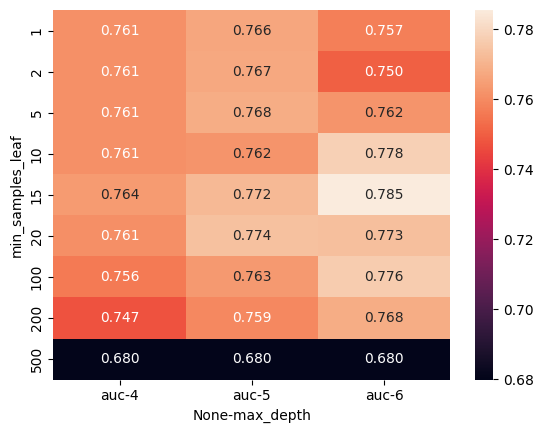

In [49]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

the lightest color would be the highest score (0.785)
- by using max_depth=6 
- and min_samples_leaf = 15

However, our 1st assumption was that Max_depth of 4, 5 and 6 are the best option, however it is possible that other values in combination with min_leaf_size would be better results...?

for this particular not big dataset, we can try other values  
however in practice we need to limit our search space somehow

In [50]:
scores = []


for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, s, auc))

df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
40,10.0,15,0.790224
58,20.0,15,0.787841
49,15.0,15,0.786164
67,NaN,15,0.785589
50,15.0,20,0.785501


We can see that the much deeper tree but with restriction of min_samples_leaf produces model with higher performance  
however, the increase is not very high and we still can use smaller tree, since it is simpler

In [51]:
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 15)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'auc score = {auc}')

auc score = 0.7848562640769174


This model will be our base model to create models ensembles by combining models together

# Random Forest - Ensembles

Putting multiple decision trees together

Consider the Example we used before:  
- client comes to bank, filles the application (different data)
- we have decision tree, it gives us score, probability of default
- based on which we make a decision whether we want to give loan  
![](./pic/10.png)

Or we may have board of experts: 5 experts
- we give copy of application to each expert
- they independently say their decision (3 Yes and 2 No)
- we think that 5 people may have better decision  
![](./pic/11.png)

the same concept for Models:
- each model may give it's probability and then
- we can aggregate these probabilities somehow (average for example)

considering decision trees: **Random Forest**
- why Random?
    - because we we train Decision Trees on the same dataset, these decision trees would be the same and would give the same results
    - we do not want to tran the same model 5 times
- In Random Forest each model is trained on the different number of features (1st model may have only 7 out of 10 features for training)  
![](./pic/12.png)

let's take the following example: we have dataset with 3 features:
- assets
- debt
- price  

and we train 3 models:
- assets+debt
- assets+price
- debt+price    
and then we aggregate the results
![](./pic/13.png)

the idea of Random Forest is that features are selected **randomly**

In [52]:
# random forest:
rf = RandomForestClassifier(n_estimators=10, random_state=1) # n_extimators - number of Decision trees inside
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [53]:
rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7848562640769174

as the result we get score, which is similar to the score we had using our best Decision Tree model

Now let's see how number of estimators influences the model's performance:

In [54]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [55]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'auc'])
df_scores.sort_values(by='auc', ascending = False).head(10)

,n_estimators,auc
19,200,0.819050
12,130,0.818253
13,140,0.818102
18,190,0.817981
15,160,0.817981
11,120,0.817939
16,170,0.817606
9,100,0.817599
10,110,0.817527
17,180,0.817463


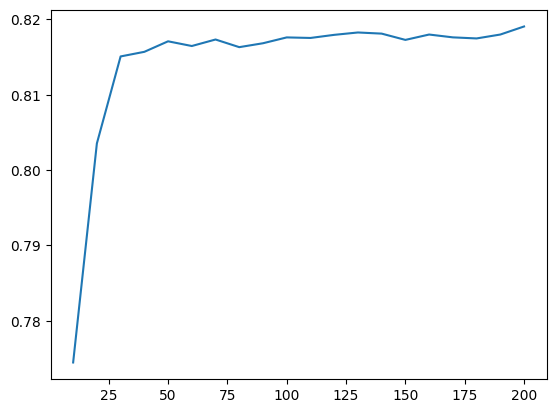

In [56]:
plt.plot(df_scores['n_estimators'], df_scores['auc'])

On the graph we can see that performance is growing till n_estimators = 50, and after that it is stagnate (increasing in n_estimators does not bring any significant improvement in performance)

#### Tuning Random Forest
we can tune parameters of Random Forest model
- max_depth
- number of estimators


In [57]:
scores = []

# tune max_depth:
for d in [5, 10, 15]:
    # tune n_estimators:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [58]:
df_scores = pd.DataFrame(scores, columns = ['max_depth', 'n_estimators', 'auc'])
df_scores.sort_values(by='auc', ascending = False).head()

,max_depth,n_estimators,auc
35,10,160,0.825243
39,10,200,0.824923
37,10,180,0.824801
36,10,170,0.824632
38,10,190,0.824535


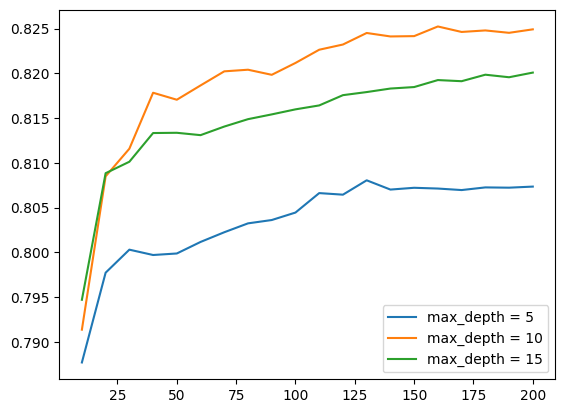

In [59]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores['max_depth'] == d]
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label=f'max_depth = {d}')

plt.legend()

- we can see that at the left part of the graph max_depth = 10 and 15 are close , but after 50 max_depth=15 grows slower  
- we see that max_depth is important parameter, since difference between max_depth = 5 and 10 is about 2.5% which is significant
- so for this dataset max_depth = 10 seems to be the best option

In [60]:
max_depth = 10

now we can do the same for min_leaf_size

In [61]:
scores = []

for m in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf = m, # test min_samples_leaf
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((m, n, auc))


In [62]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.sort_values(by='auc', ascending = False).head()

,min_samples_leaf,n_estimators,auc
58,5,190,0.825952
35,3,160,0.825655
59,5,200,0.825383
52,5,130,0.825286
37,3,180,0.825268


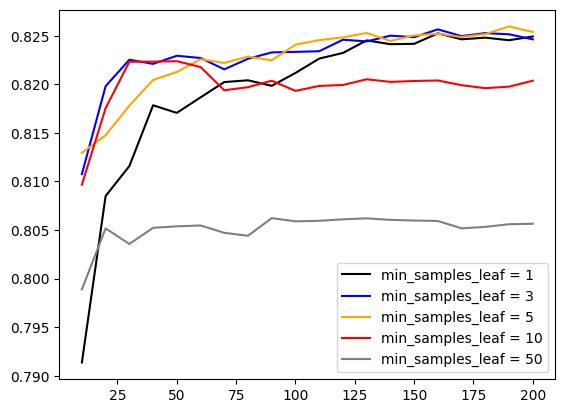

In [63]:
colors = ['black', 'blue', 'orange', 'red', 'gray']
min_samples_leaf_values = [1, 3, 5, 10, 50]
for m, c in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores['min_samples_leaf'] == m]
    plt.plot(df_subset['n_estimators'], df_subset['auc'], color=c, label=f'min_samples_leaf = {m}')

plt.legend()

- we can see that min_leaf_sample = 1, 3, 5 are relatively close, but blue (at n_estimators=50) start to grow earlier, that is why we can use this value
- we can also use n_estimators = 100 since there is no big difference between between 100 and 200

In [64]:
min_samples_leaf = 3
n_estimators = 100

In [65]:
# final model:
rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=1)

however, there are many different parameters to tune:
- max_features - number of features that are randomly selected for each decision tree (we can put Integer - number of features, or Fraction (75%))
- bootstrap - randomization by row level (select random samples)
- n_jobs - how many trees we can train in parallel (-1 - all available processors)

There are also other ways of combining decision trees: 
- we saw how it works in Random Forest - trees are independent from each other, so we can train them in parallel
- another way of combining models - when we train models sequentially (one after another) - each model corrects errors of previous models - Gradient Boosting

# Gradient Boosting and XGBoost

- in random forest we train independent models and then Aggregate their predictions
![](./pic/14.png)
  
  
- boosting - train 1st model, which gives predictions and
    - we look at the errors and we train model 2 etc
    - then we combine multiple predictions into final prediction  

    - unlike random forest, we can not train model in parallel
    ![](./pic/15.png)

if as models we use Decision Trees therefore such approach would be called **Gradient Boosting Trees** (XGBoost)

In [66]:
xgb

<module 'xgboost' from 'C:\\Users\\dein5\\AppData\\Roaming\\Python\\Python311\\site-packages\\xgboost\\__init__.py'>

after importing library, we ween to wrap our data into DMatrix data structure, which is optimized for working with XGBoost

In [67]:
# DMatrix:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [68]:
# train model:
# num boost round how many trees we want - now just some large value
xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6, # size of tree
    'min_child_weight': 1, # similar min_samples_leaf
    'objective': 'binary:logistic', # binary classification task we solving
    'nthread': 8, # how many processes go in parallel
    'seed': 1, # random seed
    'verbosity': 1, # what kind of warnings we want to see
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [69]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8003166549611296

we get value roc_auc_score = 0.8 which is quite good for default parameters

we can try to adjust num_boost_round parameter to decrease number of trees inside to 10:

In [70]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=10) # change number of trees
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8152745150274878

we got even better performance of the model

XGBoost model is also subject to overfitting, therefore we should be careful with number of trees and their depth

In XGBoost we can monitor the efficiency of training procedure:
- we can after each training iteration evaluate model on validation data:
    - for that we need to create a watch list - datasets on which we want to evaluate model:

In [71]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=10,
                  evals=watchlist)

[0]	train-logloss:0.56305	val-logloss:0.59430
[1]	train-logloss:0.48994	val-logloss:0.53906
[2]	train-logloss:0.43888	val-logloss:0.50933
[3]	train-logloss:0.40273	val-logloss:0.49005
[4]	train-logloss:0.37589	val-logloss:0.48380
[5]	train-logloss:0.35308	val-logloss:0.47809
[6]	train-logloss:0.33752	val-logloss:0.47337
[7]	train-logloss:0.32374	val-logloss:0.47236
[8]	train-logloss:0.31346	val-logloss:0.47190
[9]	train-logloss:0.30260	val-logloss:0.47274


log-loss is what logistic regression XGBoost is using to evaluate model performance  
however, it is more technical and we may want to see AUC score instead

In [72]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # default evaluation metric
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  evals=watchlist)

[0]	train-auc:0.86300	val-auc:0.76818
[1]	train-auc:0.88485	val-auc:0.79410
[2]	train-auc:0.89923	val-auc:0.80017
[3]	train-auc:0.90951	val-auc:0.80886
[4]	train-auc:0.91967	val-auc:0.80414
[5]	train-auc:0.92863	val-auc:0.80606
[6]	train-auc:0.93385	val-auc:0.80949
[7]	train-auc:0.93880	val-auc:0.81101
[8]	train-auc:0.94150	val-auc:0.81445
[9]	train-auc:0.94581	val-auc:0.81527
[10]	train-auc:0.95002	val-auc:0.81558
[11]	train-auc:0.95342	val-auc:0.81679
[12]	train-auc:0.95555	val-auc:0.81821
[13]	train-auc:0.95985	val-auc:0.81677
[14]	train-auc:0.96176	val-auc:0.81801
[15]	train-auc:0.96558	val-auc:0.81680
[16]	train-auc:0.96741	val-auc:0.81807
[17]	train-auc:0.96981	val-auc:0.81808
[18]	train-auc:0.97083	val-auc:0.81901
[19]	train-auc:0.97252	val-auc:0.81732
[20]	train-auc:0.97316	val-auc:0.81775
[21]	train-auc:0.97469	val-auc:0.81765
[22]	train-auc:0.97678	val-auc:0.81865
[23]	train-auc:0.97925	val-auc:0.81786
[24]	train-auc:0.98104	val-auc:0.81937
[25]	train-auc:0.98174	val-auc:0.81

we can see that at some point auc on training data reaches 1 - perfect model on training data, but performance on validation data starts to decrease due to overfitting

for better analysis, we can print model performance not on every step but on every 5 step for example:

In [73]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # default evaluation metric
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval = 5,
                  evals=watchlist)

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	train-auc:0.98174	val-auc:0.81878
[30]	train-auc:0.98772	val-auc:0.81787
[35]	train-auc:0.99180	val-auc:0.81510
[40]	train-auc:0.99456	val-auc:0.81387
[45]	train-auc:0.99596	val-auc:0.81462
[50]	train-auc:0.99688	val-auc:0.81128
[55]	train-auc:0.99787	val-auc:0.80874
[60]	train-auc:0.99889	val-auc:0.80801
[65]	train-auc:0.99919	val-auc:0.80751
[70]	train-auc:0.99944	val-auc:0.80732
[75]	train-auc:0.99964	val-auc:0.80692
[80]	train-auc:0.99985	val-auc:0.80677
[85]	train-auc:0.99986	val-auc:0.80671
[90]	train-auc:0.99992	val-auc:0.80637
[95]	train-auc:0.99996	val-auc:0.80580
[100]	train-auc:0.99998	val-auc:0.80508
[105]	train-auc:0.99999	val-auc:0.80603
[110]	train-auc:1.00000	val-auc:0.80527
[115]	train-auc:1.00000	val-auc:0.80382
[120]	train-auc:1.00000	val-auc:0.80431
[125]	train-auc:1.0000

- we can see that perfect performance on training data is reached on 110 between 100 and 110 iterations 
- we can also see that on the iteration 25 the best performance on validation data is achieved

we may also want to plot these data, however to get evaluation data from learning process we will need to capture logs from training process

In [74]:
%%capture output 

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # default evaluation metric
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval = 5,
                  evals=watchlist)

In [75]:
print(output)

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	train-auc:0.98174	val-auc:0.81878
[30]	train-auc:0.98772	val-auc:0.81787
[35]	train-auc:0.99180	val-auc:0.81510
[40]	train-auc:0.99456	val-auc:0.81387
[45]	train-auc:0.99596	val-auc:0.81462
[50]	train-auc:0.99688	val-auc:0.81128
[55]	train-auc:0.99787	val-auc:0.80874
[60]	train-auc:0.99889	val-auc:0.80801
[65]	train-auc:0.99919	val-auc:0.80751
[70]	train-auc:0.99944	val-auc:0.80732
[75]	train-auc:0.99964	val-auc:0.80692
[80]	train-auc:0.99985	val-auc:0.80677
[85]	train-auc:0.99986	val-auc:0.80671
[90]	train-auc:0.99992	val-auc:0.80637
[95]	train-auc:0.99996	val-auc:0.80580
[100]	train-auc:0.99998	val-auc:0.80508
[105]	train-auc:0.99999	val-auc:0.80603
[110]	train-auc:1.00000	val-auc:0.80527
[115]	train-auc:1.00000	val-auc:0.80382
[120]	train-auc:1.00000	val-auc:0.80431
[125]	train-auc:1.0000

In [76]:
# now we can parse these data:
def parse_xgb_output(output):
    results = []
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df = pd.DataFrame(results, columns=columns)

    return df

In [77]:
df_score = parse_xgb_output(output)

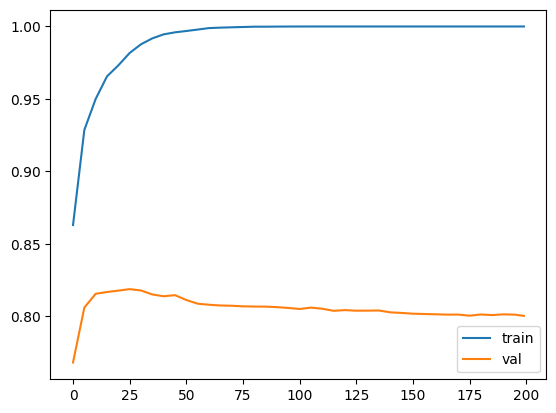

In [78]:
plt.plot(df_score['num_iter'], df_score['train_auc'], label='train')
plt.plot(df_score['num_iter'], df_score['val_auc'], label='val')
plt.legend()

we can see the point where we start overfitting - when model shows almost perfect performance on training data and results on validation data start to decrease

# XGBoost parameter tuning

- eta - learning rate  
    - when we train 2nd model, eta parameter says how much weight 2nd model has correcting results of 1st model
    - if eta = 1, therefore all the predictions of 2nd model are used to correct predictions of 1st model
    - if eta = 0.3, means that we correct only 30 % of predictions, so it is the size of predictions that we want to correct"

In [79]:
# default parameters model:
scores = {} # dictionary of scores with eta parameter as key

In [94]:
%%capture output 

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # default evaluation metric
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval = 5,
                  evals=watchlist)



In [95]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [96]:
scores.keys()

dict_keys(['eta=0.05', 'eta=1', 'eta=0.3', 'eta=0.01', 'eta=0.1'])

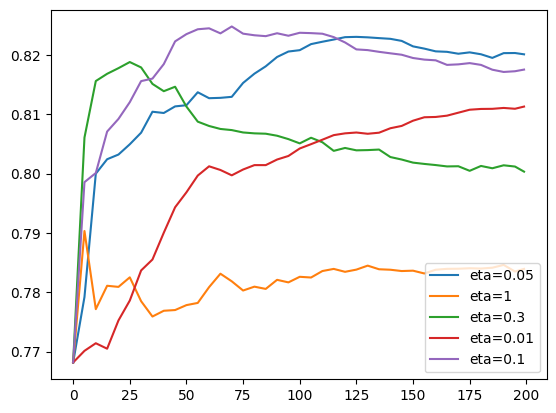

In [97]:
for key, df_score in scores.items():
    plt.plot(df_score['num_iter'], df_score['val_auc'], label=key)

plt.legend()

it is a little hard to analyze therefore we may eliminate number of graphs:

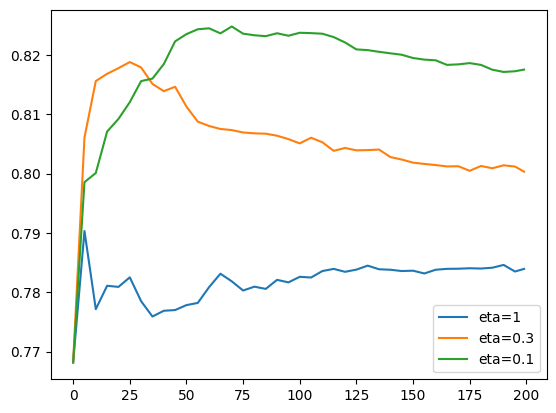

In [98]:
etas = ['eta=1', 'eta=0.3', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score['num_iter'], df_score['val_auc'], label=eta)

plt.legend()

- we can see that eta=1 shows the worst performance, at the beginning this models shows Ok increase in performance, but very soon drops significantly
- eta=0.3 we saw above. It shows good increase in the beginning and then drops after n_estimators = 50
- the best results are shown by model eta=0.1, since it grows slower, and also decreases after also slower (it does not overfit as fast as other models)

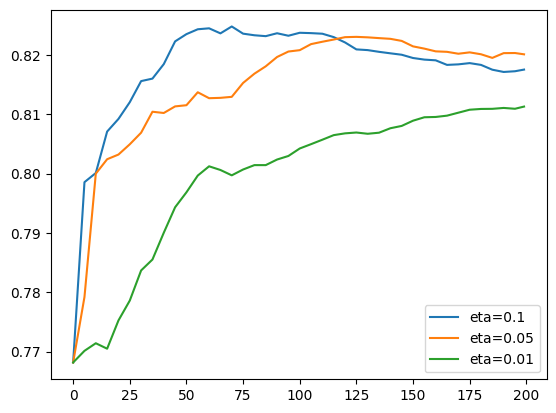

In [ ]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score['num_iter'], df_score['val_auc'], label=eta)

plt.legend()

- we can see that eta=0.01 is very slow: performance is increasing, but it takes too many iterations
- for eta=0.05 it takes almost 2 times more steps to get to maximum performance on validation set
- eta=0.1 seems to be the best one, since it does not need a lot of trees and reaches better performance on peak

so the recommended order for tuning XGBoost parameters:
1. ETA
2. Max_depth
3. min_child_weight

In [ ]:
eta = 0.1

In [ ]:
scores = {} # reset scores dict to keep track only of new experiments

In [ ]:
%%capture output 

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval = 5,
                  evals=watchlist)

key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

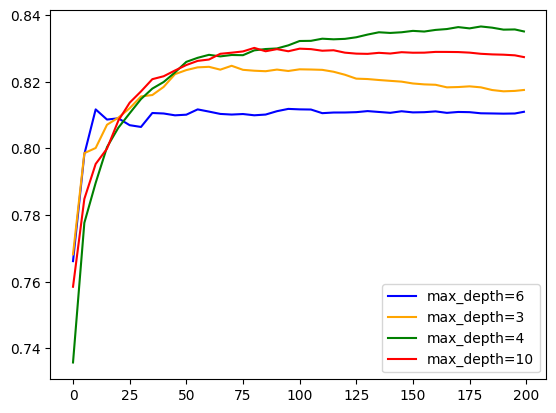

In [ ]:
colors = ['blue', 'orange', 'green', 'red']
max_depths = ['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10']

for max_depth, color in zip(max_depths, colors):
    df_subset = scores[max_depth]
    plt.plot(df_subset['num_iter'], df_subset['val_auc'], label=max_depth, color=color)

plt.legend()

we can see that max_depth = 6 grows fast and then stagnate

In [ ]:
del scores['max_depth=6']

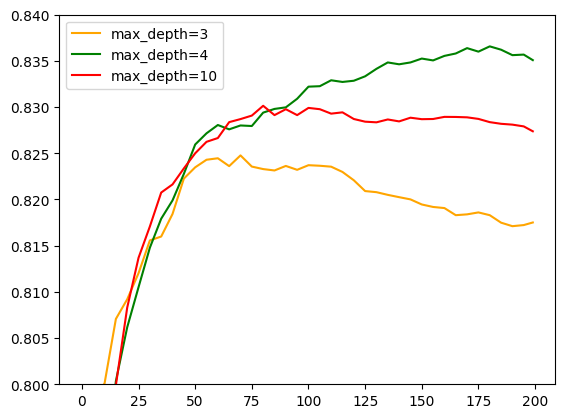

In [ ]:
colors = ['orange', 'green', 'red']
max_depths = ['max_depth=3', 'max_depth=4', 'max_depth=10']

for max_depth, color in zip(max_depths, colors):
    df_subset = scores[max_depth]
    plt.plot(df_subset['num_iter'], df_subset['val_auc'], label=max_depth, color=color)

plt.ylim(0.8, 0.84)

plt.legend()

- we can see that max_depth=3 is always worse than the others and then it also decreases fast
- max_depth=10 stagnates after 75 iterations
- and max_depth=4 grows till 180 iterations, since it takes more iterations to learn, since tree is small

In [ ]:
max_depth = 3

In [ ]:
# tune min child weight:
scores = {}

In [ ]:
%%capture output 

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': eta,
    'max_depth': max_depth,
    'min_child_weight': 30,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval = 5,
                  evals=watchlist)

key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

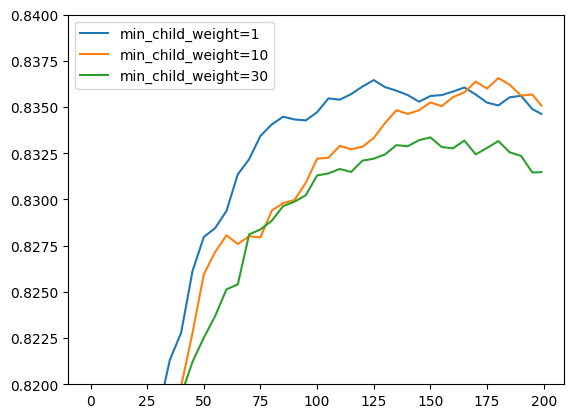

In [ ]:
for key, df_score in scores.items():
    plt.plot(df_score['num_iter'], df_score['val_auc'], label=key)

plt.ylim(0.82, 0.84)

plt.legend()

it is not worth experimenting with this parameter, since evethought we zoom close, there are no significant differences, so we would go with default

In [ ]:
%%capture output 

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [ ]:
model

there are also some important parameters for XGBoost model:
- subsample - is parameter which controls which samples are passed to specifi tree in the ensemble
    - 0.5 means that we get only 50% of the data at a time
    - we can try 0.3, 0.5, 0.7
- colsample_bytree - is similar to what we saw in Random Forest (where every tree has its own subset of columns) - this parameter controls how many features are passed to the models
    - we need to experiment with this parameter. Default value = 1.0 (all features)
    - we can try 0.6 and 0.3 and we can see which one works better


# Selecting the final model

in this project we have tuned and trained 3 different models:
- decision tree
- random forest
- xgboost model

In [ ]:
# decision tree: 
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 15)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'auc score = {auc}')

auc score = 0.785470804775859


In [ ]:
# random forest:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'auc score = {auc}')

auc score = 0.8246258264512848


In [ ]:
# xgboost:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=175)
y_pred = model.predict(dval)
auc = roc_auc_score(y_val, y_pred)
print(f'auc score = {auc}')

auc score = 0.8360387251459157


considering predictions of these models on validation dataset, we can say that XGBoost is the best model for that data

now we will use full train dataset to include validation part into training and test on test dataset

In [ ]:
df_full_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,22,owner,48,48,married,no,fixed,60,110.0,3000.0,0.0,1000,1460
1,8,other,60,41,married,no,freelance,45,62.0,0.0,0.0,1800,2101
2,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
3,1,owner,12,61,married,no,others,45,103.0,20000.0,0.0,300,650
4,13,owner,60,27,married,no,fixed,35,253.0,7000.0,0.0,1060,1750


In [ ]:
dicts_full_train = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(dicts_full_train)

In [ ]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [ ]:
# xgboost:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dfulltrain, num_boost_round=175) # final model
y_pred = model.predict(dtest)
auc = roc_auc_score(y_test, y_pred)
print(f'auc score = {auc}')

auc score = 0.8324067738624701


final model shows quite similar results on Test dataset as were shown on Validation data, therefore we can make a conclusion that model handles unseen data well. Model is not overfitted.  
Although, we extensively used validation dataset for parameters tuning, we did not accidently overfitted model

- XGBoost is often the best model by performance
- However it is more complex
- It has more parameters to tune
- It is easy to overfit XGBoost